In [22]:
import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams.update({'font.size': 20})
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt, welch, tukey

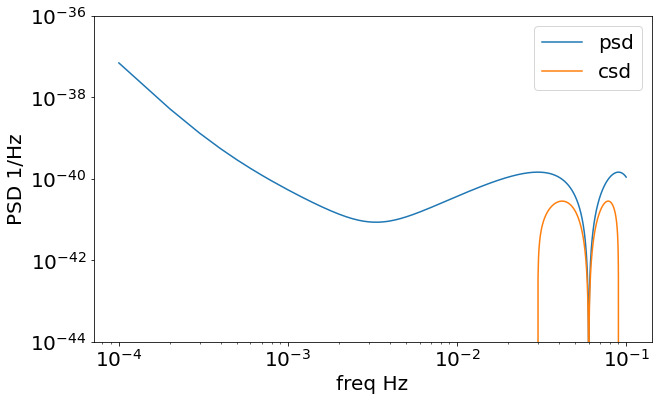

In [140]:
def psd_noise(freqs, plot=0):
    
    Np, Na = 9e-42, 3.6e-49
    
    
    Sp = Np*(1 + (2e-3/freqs)**4)
    Sa = Na*(1 + 16e-8/freqs**2)*(1 + (freqs/8e-3)**4)*(1.0/(2*np.pi*freqs)**4)
    
    fstar = 3e8/(2 * np.pi * 2.5e9)
    f0 = freqs/(2*fstar)
    
    
    psd_mich  = 4.0 * (2.0 * Sa * (1.0 + (np.cos(2*f0))**2)  + Sp)
    csd_mich  =  (-2 * Sp - 8 * Sa) * np.cos(2*f0)
    
    # psd for xyz channels
    psd = 4 * np.sin(2*f0)**2 * psd_mich
    csd = 4 * np.sin(2*f0)**2 * csd_mich
    
    #data = np.loadtxt('lisa_psd.txt')
    #f_req, psd_req, csd_req = data[0, :], data[1, :], data[2, :]

    #psd = np.interp(freqs, f_req, np.log10(psd_req))
    #psd = 10**psd
    
    
    if plot:
        plt.loglog(freqs, psd, label='psd')
        plt.loglog(freqs, csd, label='csd')
        plt.legend()
        plt.xlabel('freq Hz')
        plt.ylim([1e-44, 1e-36])
        plt.ylabel('PSD 1/Hz')
    else:
        return psd
    
## --------------------------------
psd_noise(freqs=np.arange(1e-4, 1e-1, 1e-4), plot=1)

The noise correlation is defined as (Eq 5.107 Bendot & Piersol)

$T_n = \frac{2}{R_{xx}(0)}\int_0^{\infty} d \tau | R_{xx}(\tau)|$  

We can calculate the time-domain auto-correlation function $R_{xx}$ using the real-ifft of the one-sided PSD $G_{xx}(f)$ (Eq 5.35 Bendot & Piersol)

$R_{xx} (\tau) = \int_0^{\infty} df G_{xx}(f) \cos(2\pi f \tau) $

In [119]:
def noi_corr_dur(fs=0.25, dur=1e6, **kwargs):
    
    # Number of data points in the time series
    N = int(fs*dur)
    
    # We will make an array of the desired frequencies
    fout = np.fft.rfftfreq(N, 1.0/fs)
    fout = fout[1:]
    Sh = psd_noise(fout, plot=0)

    if len(kwargs) > 0:
        fmin = float(kwargs['fmin'])
        fmax = float(kwargs['fmax'])
    else:
        fmin = fout[0] # cut out f = 0
        fmax = fout[-1]
        
    Sh[fout < fmin] = 0
    Sh[fout > fmax] = 0
        
    Rxx = np.fft.irfft(Sh)
    
    Rxx_0 = Rxx[0]
    
    tau_vals = np.arange(Rxx.size)/fs
    dtau = tau_vals[1] - tau_vals[0]
    
    Tn = 2*np.trapz(np.abs(Rxx), x = tau_vals)/Rxx_0
    

    #print('Noise correlation duration = ' + str(round(Tn , 1)) + ' s with fs = ' + str(fs) + ', fmin = ' + str(fmin) + ', fmax = ' + str(fmax))
    print('Noise correlation duration = ' + "{:.2e}".format(Tn) + ' s with fs = ' + str(fs) + ', fmin = ' + str(fmin) + ', fmax = ' + str(fmax))
    
    print('The noise correlation duration is ' + str(round(Tn/dur * 100, 2)) + ' % of the segment duration ') 
            
    plt.loglog(tau_vals[0:int(0.5*tau_vals.size)], np.abs(Rxx[0:int(0.5*tau_vals.size)])/Rxx_0, linewidth=1)
    plt.xlabel('$\\tau$ in s')
    plt.axvline(1e4, color='r', linewidth=1)
    plt.ylabel('$\\dfrac{|R_{xx}( \\tau )| }{ R_{xx}(0)}$')
    plt.savefig('auto_corr.pdf', dpi=150, bbox_inches='tight')

Noise correlation duration = 1.72e+06 s with fs = 0.25, fmin = 1e-06, fmax = 0.125
The noise correlation duration is 171.72 % of the segment duration 


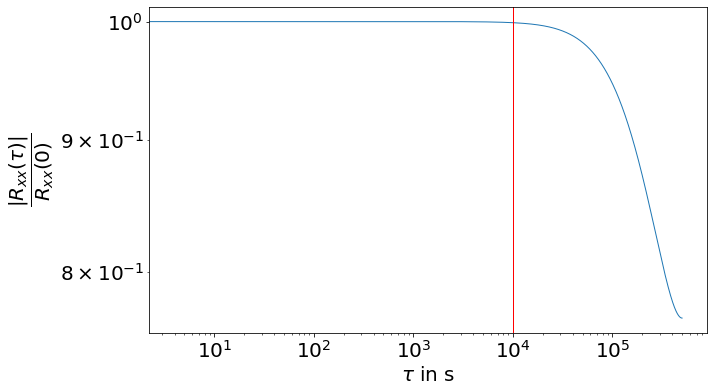

In [120]:
noi_corr_dur(fs=0.25, dur=1e6)

Noise correlation duration = 2.69e+04 s with fs = 0.25, fmin = 0.0001, fmax = 0.01
The noise correlation duration is 53.82 % of the segment duration 


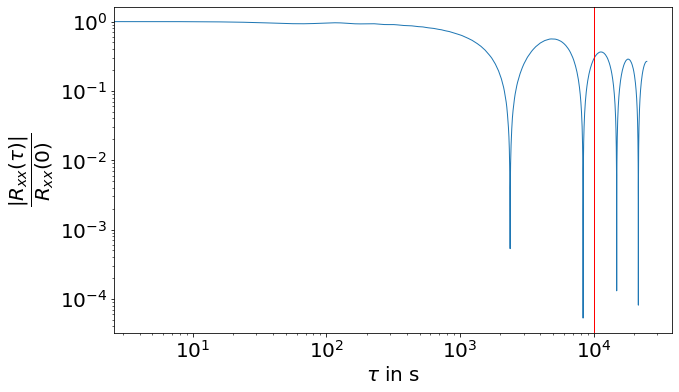

In [123]:
noi_corr_dur(fs=0.25, dur=5e4, fmin=1e-4, fmax=1e-2)

Noise correlation duration = 4.01e+04 s with fs = 0.25, fmin = 0.0001, fmax = 0.01
The noise correlation duration is 20.04 % of the segment duration 


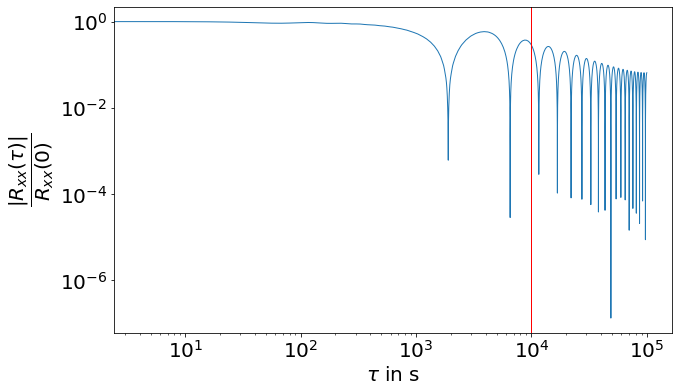

In [126]:
noi_corr_dur(fs=0.25, dur=2e5, fmin=1e-4, fmax=1e-2)

Noise correlation duration = 5.52e+04 s with fs = 0.25, fmin = 0.0001, fmax = 0.01
The noise correlation duration is 5.52 % of the segment duration 


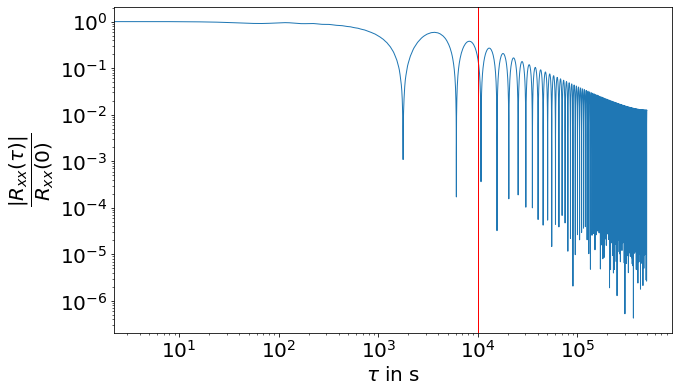

In [125]:
noi_corr_dur(fs=0.25, dur=1e6, fmin=1e-4, fmax=1e-2)

Noise correlation duration = 6.48e+03 s with fs = 0.25, fmin = 0.0002, fmax = 0.02
The noise correlation duration is 6.48 % of the segment duration 


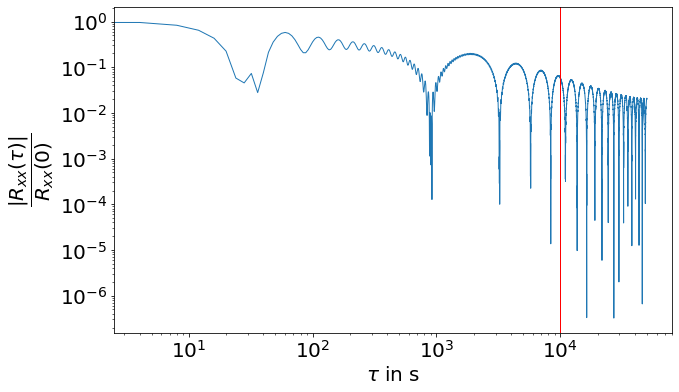

In [137]:
noi_corr_dur(fs=0.25, dur=1e5, fmin=2e-4, fmax=2e-2)